# **Modules**

In [1]:
import os # working with files
import cv2 # openCV for images
import warnings # suppress anoying warnings
from PIL import Image # image library
import matplotlib.pyplot as plt # ploting the images
import tensorflow as tf
from tensorflow import keras # deep learning module
from tensorflow.keras import layers, models # more models to train with
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data augmentation, for increasing the size and variability of training
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers, optimizers
from livelossplot import PlotLossesKeras

# **Importing data**

In [2]:
# train dataset for training models
train_csv = pd.read_csv('./train.csv')
train_csv.head()

,image_id,label
0,dd9cebaea09b6b8b54bbed1ddfa0218fe5e745fd695067...,2
1,27424caa08a7e9a0252e3c1aadb54b81cb9878856bffd0...,1
2,7391993e601411f9d5466a3e15b40557bd9fe967184ff2...,2
3,d048efa99ae5dd66d36af1d7ec93b945cc10c57c613a90...,2
4,afb83bdd05793ee69eff8080747fdf04d6e3e7d9f0889e...,0


In [3]:
# validation dataset for making prediction with, finding the best models & tuning hyperparameters
validation_csv = pd.read_csv('./validation.csv')
validation_csv.head()

,image_id,label
0,b0a6e1d35da17edb7ba0d4a7ab186217bee84031c62d1d...,2
1,e929acaa0b9db29d551b546d7d563df47ddae049b5b1c4...,0
2,a20c68fb44d99076249495d29a1883dfe917080eb991b5...,1
3,e9da21853d9071f1be851910f3bef408874ff7f5c4aa0b...,2
4,0c9312a4de70edf89ee04a502b1f86f514d76b1ed0e191...,1


In [4]:
# test dataset for final predictions, finding the accuracy
test_csv = pd.read_csv('./test.csv')
test_csv.head()

,image_id
0,2fa3cdbb4777a38ab109f4c9d6ef22932c270c608901ba...
1,2e63b14f4b7a3240dfbedb1786ab0debaa51c8b9b58892...
2,1c13ad69bd7309b44755ebfcd6c147b8da74a5340414f9...
3,080faaabc2a70263cad27f5c9e5eab60decaa2675dc4c7...
4,a17e9987e175b9a61704f8f6ecbbbdd004bee53ef37b62...


In [5]:
test_csv.isna()

,image_id
0,False
1,False
2,False
3,False
4,False
...,...
4495,False
4496,False
4497,False
4498,False


In [6]:
# handligns warnings
warnings.filterwarnings("ignore", category=UserWarning, module='cv2')

In [7]:
# paths
train_images_folder_path = './train/'
validation_images_folder_path = './validation/'
test_images_folder_path = './test/'

In [8]:
# importing train, test, validation images too
train_images_names = train_csv['image_id'].values
validation_images_names = validation_csv['image_id'].values
test_images_names = test_csv['image_id'].values
test_images_names.shape


(4500,)

In [9]:
train_images = [] # holding train images pixels
validation_images = [] # holding validation images pixels
test_images = [] # holding test images pixels

In [10]:
# function for looping through each image name, read the image, and append it to the list
def convert_image_to_array(image_folder_path, image_names, target_list):
    for image_name in image_names:
        image_path = os.path.join(image_folder_path, image_name + ".png") 
        try:
            with Image.open(image_path) as img:
                img = img.convert("RGB") # remove any problematic color profiles 
                img_array = np.array(img)
                img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
                target_list.append(img_bgr)
        except FileNotFoundError:
            print(f"Warning {image_name} could not be opened!")

In [11]:
# using the function
convert_image_to_array(train_images_folder_path, train_images_names, train_images)

In [12]:
convert_image_to_array(validation_images_folder_path, validation_images_names, validation_images)

In [13]:
convert_image_to_array(test_images_folder_path, test_images_names, test_images)

In [14]:
# converting the list of images to a NumPy array
train_images_array = np.array(train_images)
validation_images_array = np.array(validation_images)
test_images_array = np.array(test_images)
test_images_array.shape

(4500, 80, 80, 3)

# **Data visualization**

In [15]:
# shape for datasets
print(f"Training dataset shape: {train_csv.shape}")
print(f"Validation dataset shape: {validation_csv.shape}")
print(f"Testing dataset shape: {test_csv.shape}")

Training dataset shape: (10500, 2)
Validation dataset shape: (3000, 2)
Testing dataset shape: (4500, 1)


In [16]:
# shape for images in pixels 80 x 80
print(f"Training images shape: {train_images_array.shape}")
print(f"Validation images shape: {validation_images_array.shape}")
print(f"Testing images shape: {test_images_array.shape}")

Training images shape: (10500, 80, 80, 3)
Validation images shape: (3000, 80, 80, 3)
Testing images shape: (4500, 80, 80, 3)


In [17]:
type(test_images_array) # numpy array

numpy.ndarray

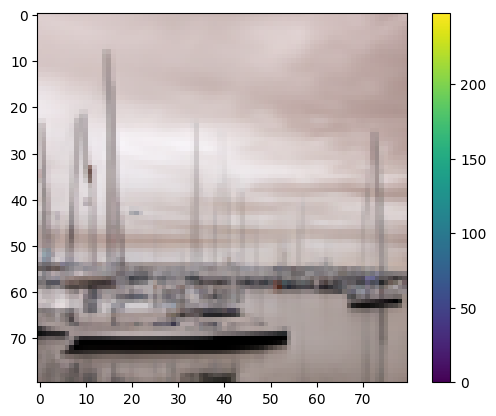

'dd9cebaea09b6b8b54bbed1ddfa0218fe5e745fd6950674324949ce09871a998'

In [18]:
# see the first image from train images
plt.figure()
plt.imshow(train_images_array[0])
plt.colorbar()
plt.grid(False)
plt.show()
train_images_names[0]

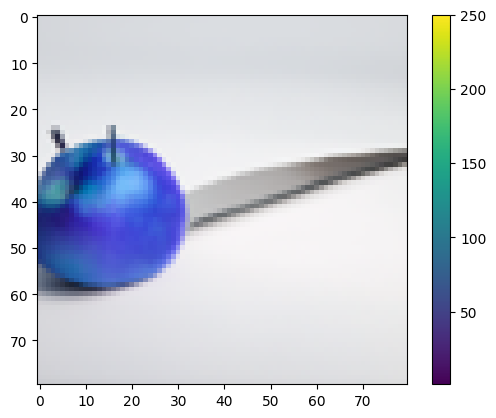

In [19]:
# first image from validation
plt.figure()
plt.imshow(validation_images_array[0])
plt.colorbar()
plt.grid(False)
plt.show()

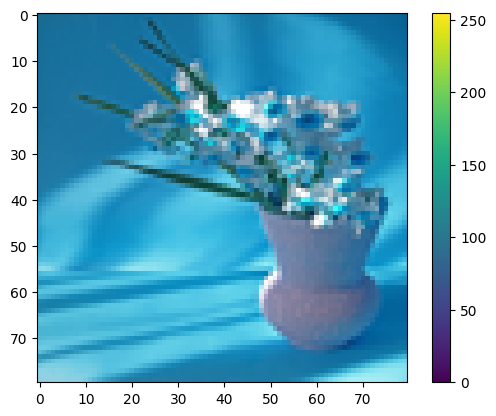

In [20]:
# first image from test
plt.figure()
plt.imshow(test_images_array[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [21]:
# train labels from 0 to 9 (first ten)
train_csv['label'][:15]

0     2
1     1
2     2
3     2
4     0
5     0
6     0
7     2
8     1
9     1
10    1
11    2
12    0
13    2
14    1
Name: label, dtype: int64

In [22]:
train_csv.isna().sum() # no NaN values

image_id    0
label       0
dtype: int64

In [23]:
test_csv.isna().sum() # no NaN values

image_id    0
dtype: int64

In [24]:
validation_csv.isna().sum() # no NaN values

image_id    0
label       0
dtype: int64

In [25]:
train_labels = train_csv['label']

In [26]:
validation_labels = validation_csv['label']

# **Data Preprocessing**

In [27]:
# normalize data for the computer to read easily (values between 0 and 1)
train_images_array = train_images_array / 255.0 
validation_images_array = validation_images_array / 255.0 
test_images_array = test_images_array / 255.0

# **Training, prediction & testing**

In [28]:
# creating the Model with CNN Architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(3, activation='softmax'))

C:\Users\mariu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# data Aagmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(train_images_array)

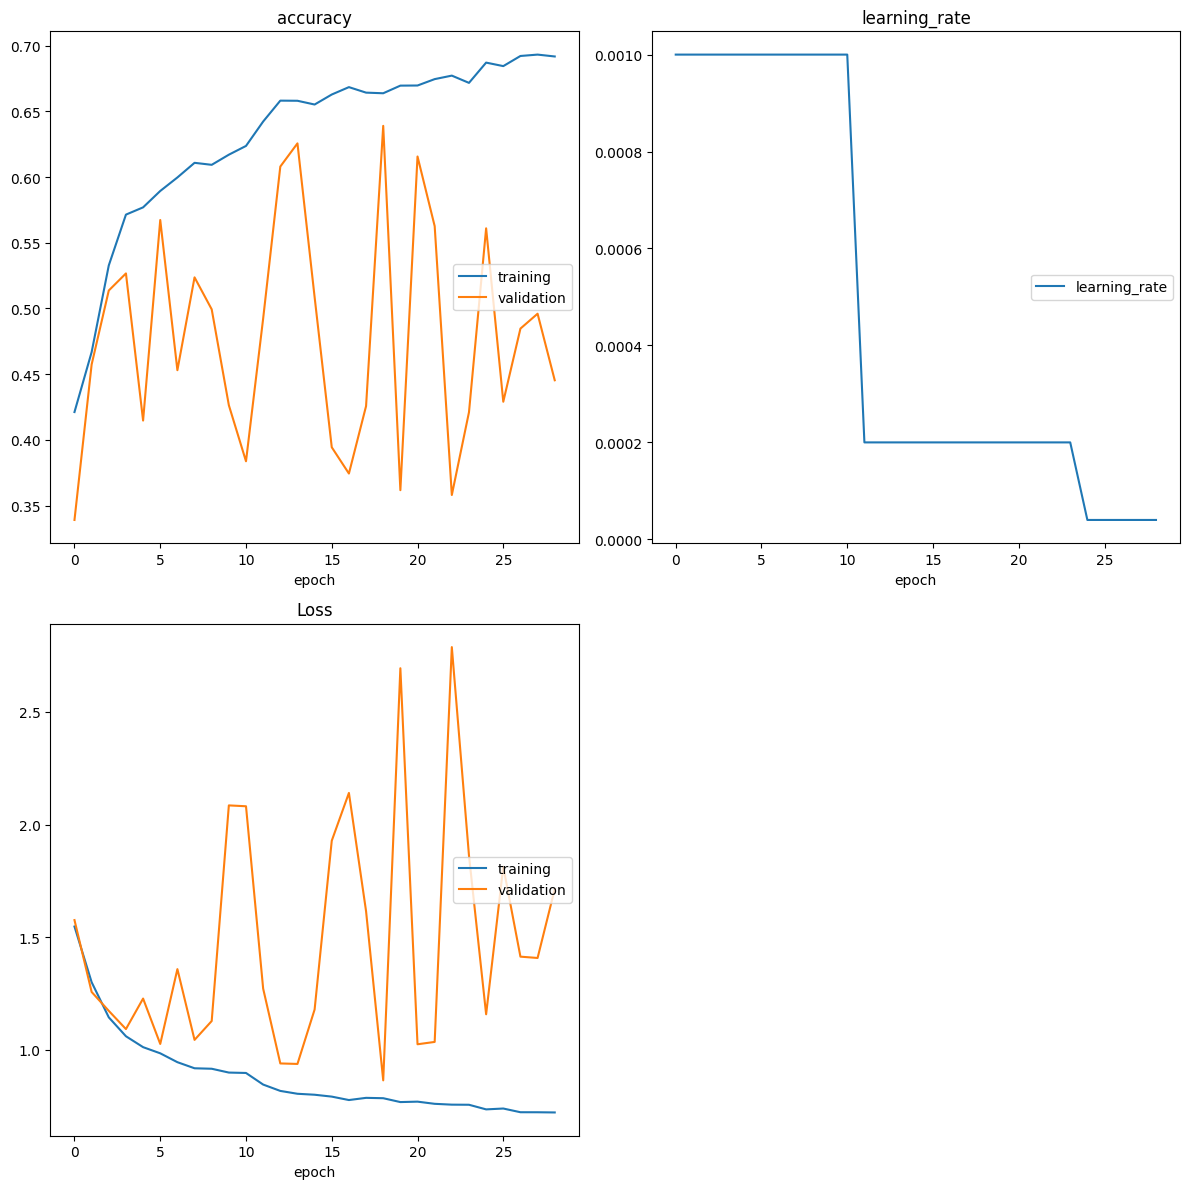

accuracy
	training         	 (min:    0.421, max:    0.693, cur:    0.692)
	validation       	 (min:    0.339, max:    0.639, cur:    0.445)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    0.722, max:    1.548, cur:    0.722)
	validation       	 (min:    0.865, max:    2.788, cur:    1.714)
329/329 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - accuracy: 0.6958 - loss: 0.7184 - val_accuracy: 0.4453 - val_loss: 1.7139 - learning_rate: 4.0000e-05


In [30]:
# compiling the model
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

# callbacks
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.keras', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# model training
history = model.fit(datagen.flow(train_images_array, train_labels), 
                    epochs=40, 
                    validation_data=(validation_images_array, validation_labels), 
                    callbacks=[checkpointer, early_stop, reduce_lr, PlotLossesKeras()])

In [31]:
# Test the Model
test_loss, test_acc = model.evaluate(validation_images_array, validation_labels, verbose = 2)

94/94 - 2s - 20ms/step - accuracy: 0.6390 - loss: 0.8648


In [32]:
# Predict
predictions = model.predict(test_images_array)

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [33]:
# prediction for a class
y_predictions = np.argmax(predictions, axis = 1)
y_predictions

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [34]:
test_images_array.shape

(4500, 80, 80, 3)

# **Output the csv**

In [35]:
test_csv

,image_id
0,2fa3cdbb4777a38ab109f4c9d6ef22932c270c608901ba...
1,2e63b14f4b7a3240dfbedb1786ab0debaa51c8b9b58892...
2,1c13ad69bd7309b44755ebfcd6c147b8da74a5340414f9...
3,080faaabc2a70263cad27f5c9e5eab60decaa2675dc4c7...
4,a17e9987e175b9a61704f8f6ecbbbdd004bee53ef37b62...
...,...
4495,01ac8a0f476ef01dcd550af3cbffa8bfbf878f035b63fb...
4496,2b81865dec0ed84deffb4bc707c9f9bdcf434a0128f19d...
4497,568c0c5bf9873da2d7e823ef7873491d35418365dd112a...
4498,a8f97c593f24025c4d3d46e52a1d8cfa476d22ee1bfa7a...


In [36]:
output_images = pd.DataFrame({'image_id': test_csv['image_id'], 'label': y_predictions})
output_images.to_csv('predictions.csv', index = False)